Loading preprocessed EDA data...

Processing sub-01 - empty_bright
Data length: 2981 samples (298.1 seconds)
Number of SCR peaks detected: 59
Mean SCR amplitude: 0.3696


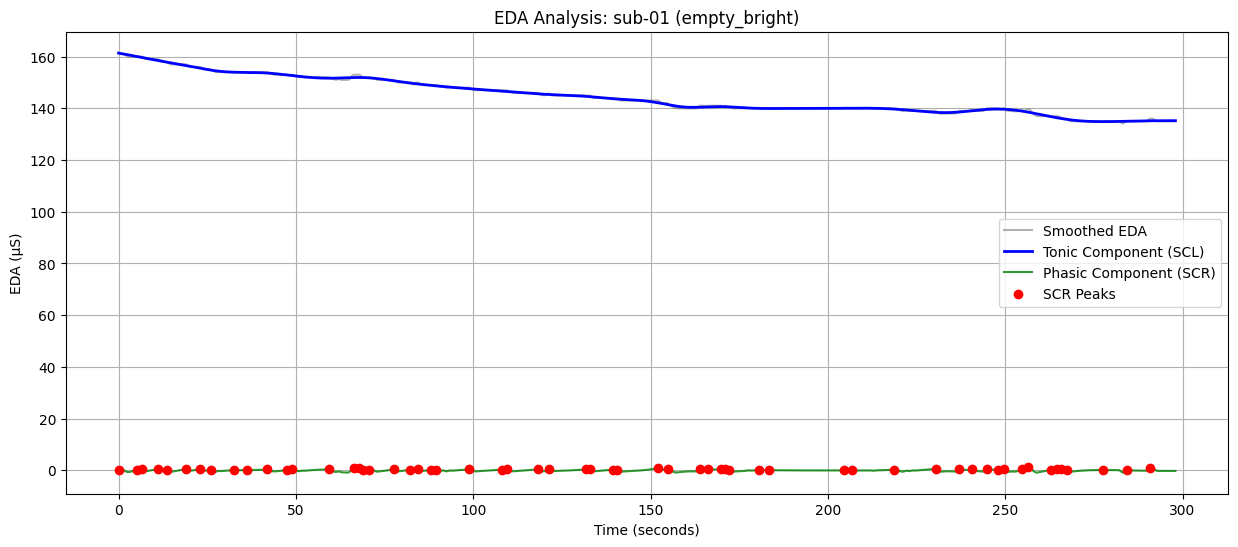


Processing sub-01 - empty_dark
Data length: 2381 samples (238.1 seconds)
Number of SCR peaks detected: 45
Mean SCR amplitude: 0.2854


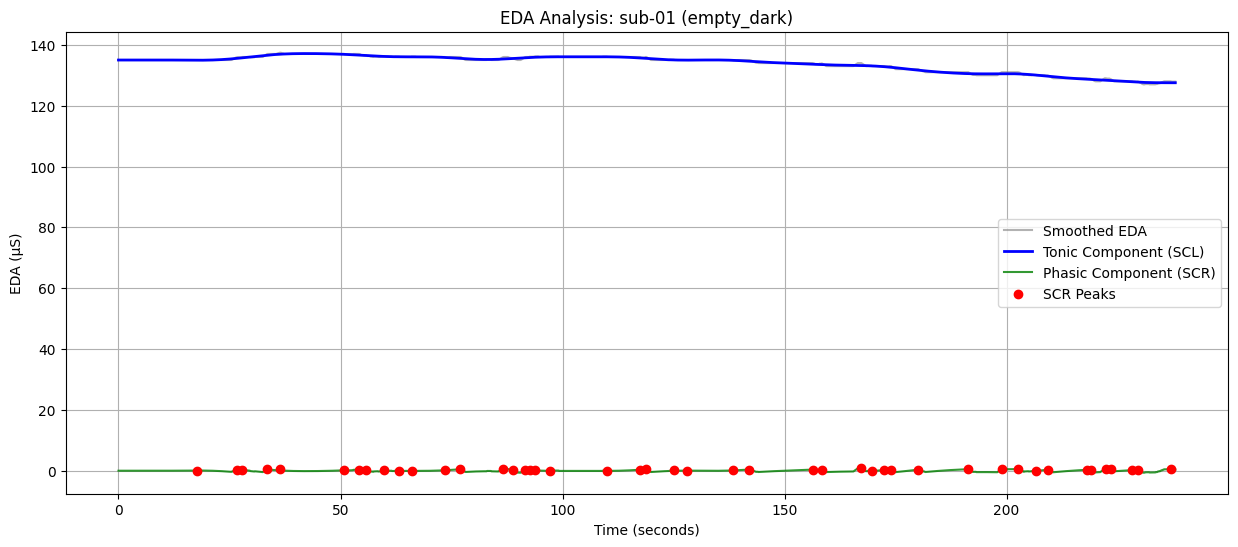


Processing sub-01 - full_bright
Data length: 3581 samples (358.1 seconds)
Number of SCR peaks detected: 72
Mean SCR amplitude: 2.3868


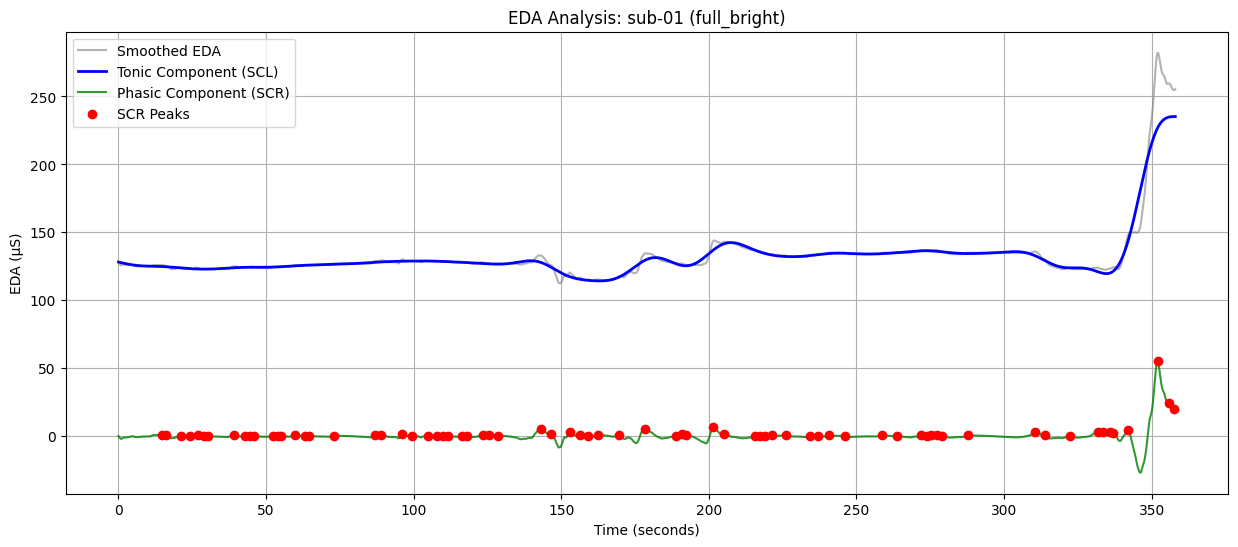


Processing sub-01 - full_dark
Data length: 1791 samples (179.1 seconds)
Number of SCR peaks detected: 26
Mean SCR amplitude: 3.5003


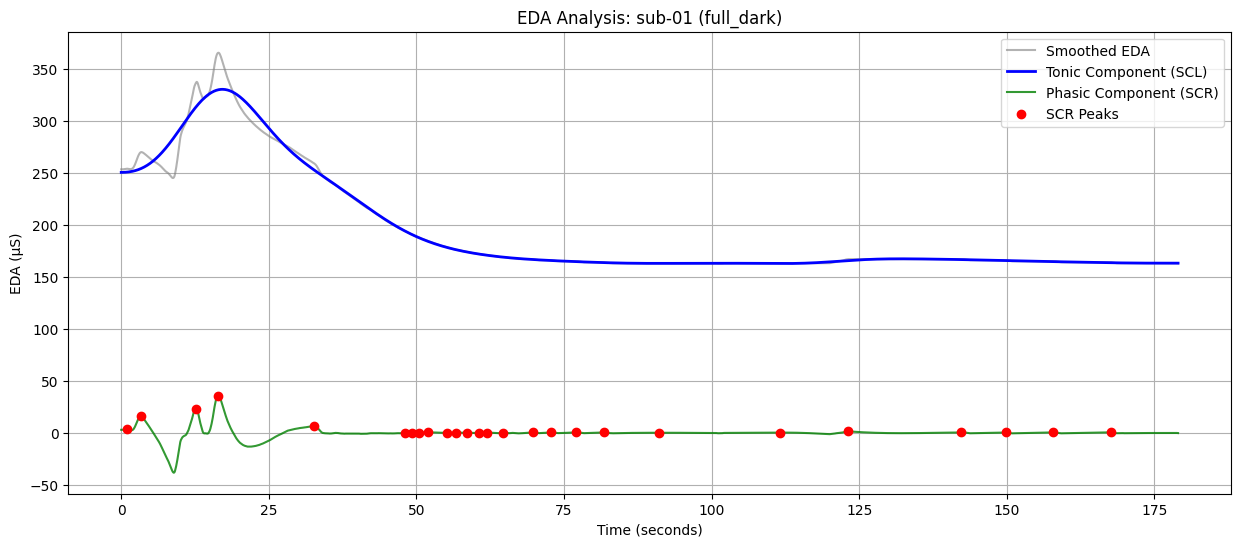


Processing sub-02 - empty_bright
Data length: 2981 samples (298.1 seconds)
Number of SCR peaks detected: 85
Mean SCR amplitude: 1.5749


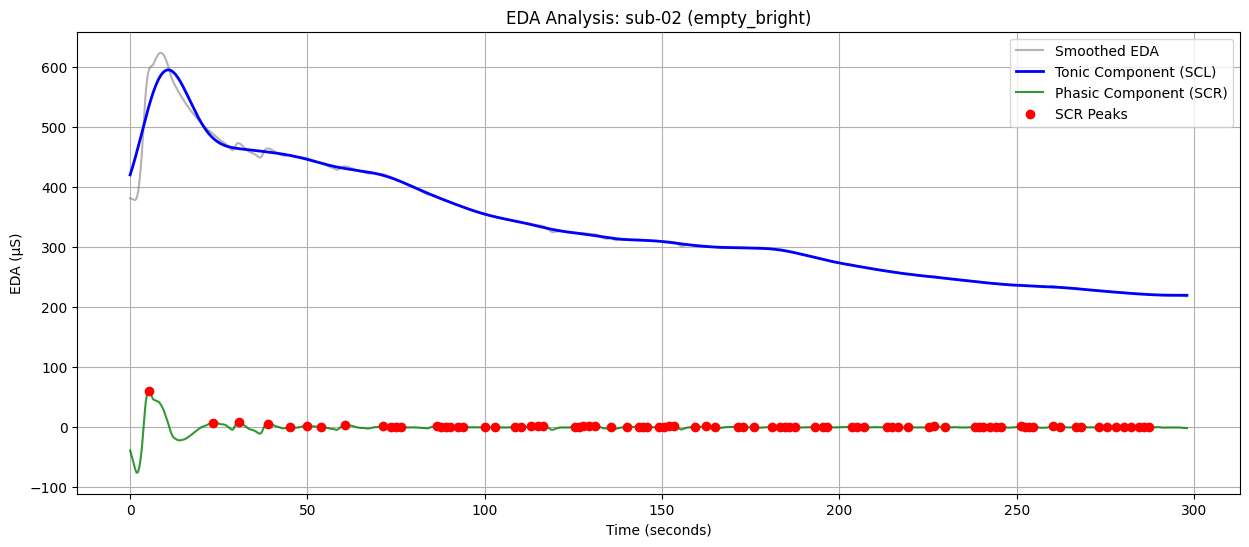


Processing sub-02 - empty_dark
Data length: 2381 samples (238.1 seconds)
Number of SCR peaks detected: 68
Mean SCR amplitude: 0.3456


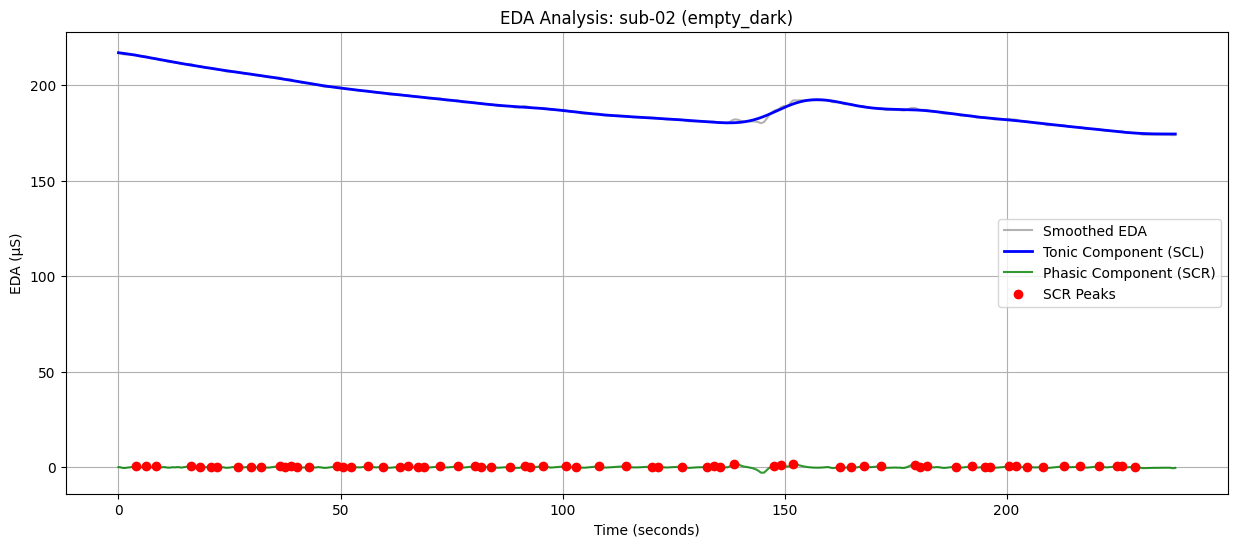


Processing sub-02 - full_bright
Data length: 3581 samples (358.1 seconds)
Number of SCR peaks detected: 76
Mean SCR amplitude: 5.4195


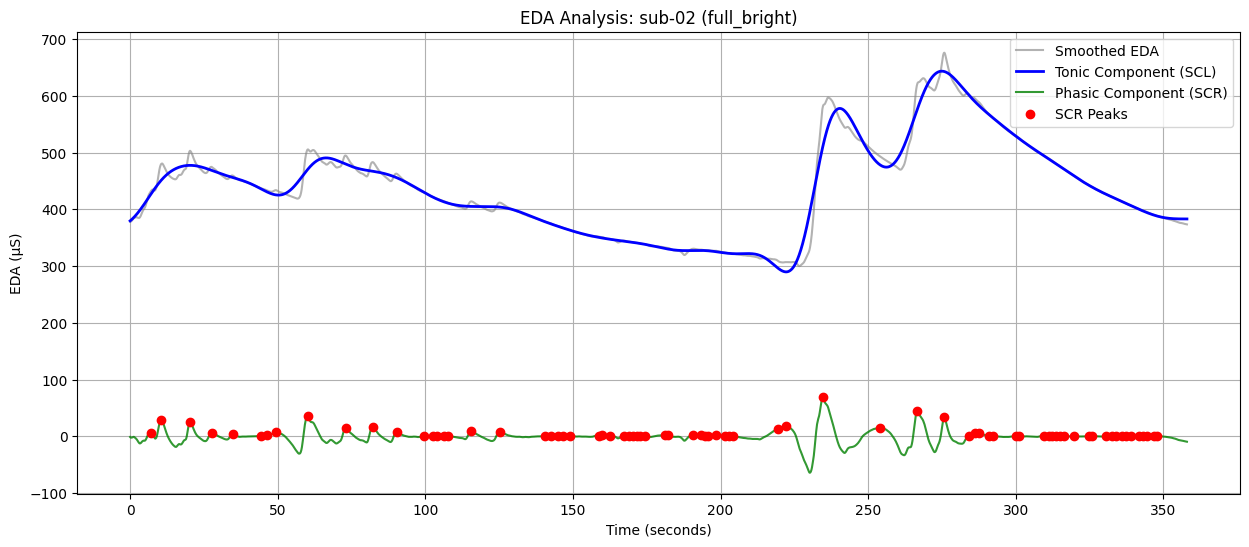


Processing sub-02 - full_dark
Data length: 1791 samples (179.1 seconds)
Number of SCR peaks detected: 29
Mean SCR amplitude: 4.7763


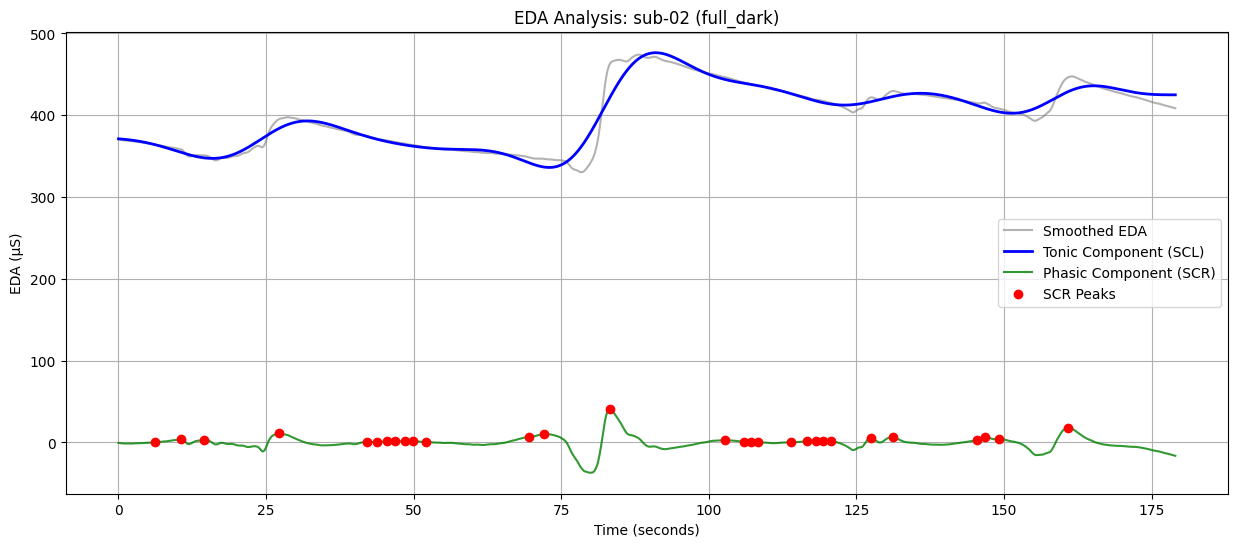


Saving processed data...
Processing complete!


In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt
import pickle

def low_pass_filter(data, cutoff, fs, order=4):
    """Apply low-pass Butterworth filter"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# File path
derivative_folder = '/Users/firefly/Desktop/Team_Messung/data/preprocessed-data'
output_filename = f"{derivative_folder}/preprocessed_eda.pkl"

# Load the preprocessed data
print("Loading preprocessed EDA data...")
with open(output_filename, 'rb') as f:
    loaded_data = pickle.load(f)

# Parameters
sampling_frequency = 10  # Downsampled to 10 Hz
cutoff_frequency = 0.05  # Cutoff for tonic component
peak_threshold = 0.02    # Threshold for SCR detection

# Process each dataset
for participant_data in loaded_data:
    participant = participant_data['participant']
    condition = participant_data['condition']
    
    # Get smoothed EDA data and remove NaN values
    eda_data = participant_data['smoothed'].dropna().values
    time = np.arange(len(eda_data)) / sampling_frequency
    
    print(f"\nProcessing {participant} - {condition}")
    print(f"Data length: {len(eda_data)} samples ({len(eda_data)/sampling_frequency:.1f} seconds)")
    
    # 1. Extract Tonic Component (SCL)
    tonic_component = low_pass_filter(eda_data, cutoff_frequency, sampling_frequency)
    
    # 2. Extract Phasic Component (SCR)
    phasic_component = eda_data - tonic_component
    
    # 3. Detect SCR peaks
    peaks, _ = find_peaks(phasic_component, 
                         height=peak_threshold, 
                         distance=sampling_frequency)  # Minimum 1 second between peaks
    
    # Calculate SCR amplitudes
    scr_amplitudes = phasic_component[peaks]
    
    # Store results in participant_data
    participant_data['tonic_component'] = tonic_component
    participant_data['phasic_component'] = phasic_component
    participant_data['scr_peaks'] = peaks
    participant_data['scr_amplitudes'] = scr_amplitudes
    
    print(f"Number of SCR peaks detected: {len(peaks)}")
    print(f"Mean SCR amplitude: {np.mean(scr_amplitudes):.4f}")
    
    # Visualize results
    plt.figure(figsize=(15, 6))
    
    # Plot all components
    plt.plot(time, eda_data, 
             label="Smoothed EDA", alpha=0.6, color='gray')
    plt.plot(time, tonic_component, 
             label="Tonic Component (SCL)", linewidth=2, color='blue')
    plt.plot(time, phasic_component, 
             label="Phasic Component (SCR)", alpha=0.8, color='green')
    plt.scatter(peaks / sampling_frequency, scr_amplitudes, 
               color="red", label="SCR Peaks", zorder=5)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("EDA (µS)")
    plt.title(f"EDA Analysis: {participant} ({condition})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Save updated data with EDA analysis results
print("\nSaving processed data...")
with open(output_filename, 'wb') as f:
    pickle.dump(loaded_data, f)

print("Processing complete!")